In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

In [14]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark Decision Tree classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true') \
                .load("../data/WineData2.csv",header=True);
df.show(5,True)

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8|      5|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8|      6|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4|      5|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows



In [6]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

In [7]:
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

In [8]:
df = df.withColumn("quality", quality_udf("quality"))
df.show(5,True)
df.printSchema()

+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|fixed|volatile|citric|sugar|chlorides|free|total|density|  pH|sulphates|alcohol|quality|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
|  7.8|    0.88|   0.0|  2.6|    0.098|25.0| 67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|  7.8|    0.76|  0.04|  2.3|    0.092|15.0| 54.0|  0.997|3.26|     0.65|    9.8| medium|
| 11.2|    0.28|  0.56|  1.9|    0.075|17.0| 60.0|  0.998|3.16|     0.58|    9.8| medium|
|  7.4|     0.7|   0.0|  1.9|    0.076|11.0| 34.0| 0.9978|3.51|     0.56|    9.4| medium|
+-----+--------+------+-----+---------+----+-----+-------+----+---------+-------+-------+
only showing top 5 rows

root
 |-- fixed: double (nullable = true)
 |-- volatile: double (nullable = true)
 |-- citric: double (nullable = true)
 |-- sugar: double (nullable = true)
 |-- chl

In [9]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [10]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [11]:
#dealing with categorical values
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [12]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [13]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[5.0,0.38,0.01,1....|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,0.74,0.0,1.2...|medium|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.7,0.6,0.17,2.3...|medium|
|[4.9,0.42,0.0,2.1...|  high|
|[5.1,0.42,0.0,1.8...|  high|
|[5.1,0.51,0.18,2....|  high|
|[5.2,0.32,0.25,1....|medium|
+--------------------+------+
only showing top 5 rows



In [15]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [16]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [17]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

In [18]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [19]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|          high|
|[5.1,0.42,0.0,1.8...|  high|          high|
|[5.1,0.51,0.18,2....|  high|          high|
|[5.2,0.32,0.25,1....|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [20]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.149371
RandomForestClassificationModel (uid=RandomForestClassifier_f7a7e41d01e6) with 10 trees


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)
# # # print(class_name)
class_names

In [24]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[510,  16,   0],
       [ 53,  31,   0],
       [ 26,   0,   0]])

Confusion matrix, without normalization
[[510  16   0]
 [ 53  31   0]
 [ 26   0   0]]


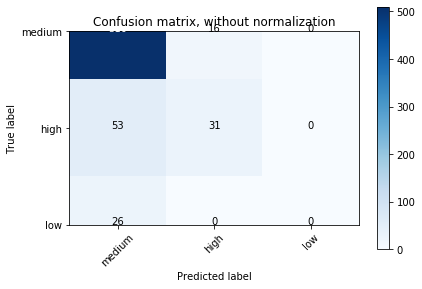

In [25]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.96958175 0.03041825 0.        ]
 [0.63095238 0.36904762 0.        ]
 [1.         0.         0.        ]]


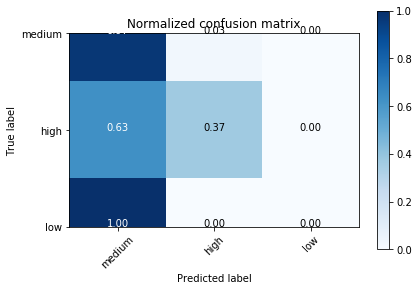

In [27]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()